![MOSEK ApS](https://mosek.com/files/mosek_logo_color.png )

Smallest sphere enclosing a set of points.
===========================

The aim of this tutorial is two-fold

1. Demostrate how to write a conic quadratic model in `Fusion` in a very simple and compact way.
2. Show how and way the dual formulation may solved more efficiently.


Our problem is the defined as:

**Find the smallest sphere that encloses a set of** $k$ **points** $p_i \in \mathbb{R}^n$. 

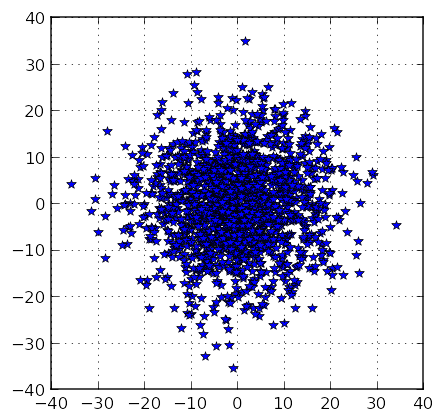

In [75]:
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import random

def plot_points(p, p0=[], r0=0.):
    n,k= len(p0), len(p)
    
    plt.rc('savefig',dpi=120)

    fig, ax = plt.subplots()
    ax.set_aspect('equal')
    ax.plot([ p[i][0] for i in range(k)], [ p[i][1] for i in range(k)], 'b*')
    
    if len(p0)>0:
        ax.plot(  p0[0],p0[1], 'r.')
        ax.add_patch( mpatches.Circle( p0,  r0 ,  fc="w", ec="r", lw=1.5) )
    plt.grid()
    plt.show()

n = 2
k = 1500

p=  [ [random.gauss(0.,10.) for nn in range(n)] for kk in range(k)]

plot_points(p)

The problem boils down to determine the sphere center $p_0\in \mathbb{R}^n$ and its radius $r_0\geq 0$, i.e.


\begin{equation}
  \begin{aligned}
\min \max_{i=1,\dots,k} \| p_0 - p_i\|_2 \\
  \end{aligned}
\end{equation}

The maximum in the objective function can be easily, i.e.

\begin{equation}
  \begin{aligned}
\min r_0 & & &\\
s.t.& & &\\
& r_i \geq \| p_0 - p_i\|_2 ,& \quad & i=1,\ldots,k\\
\end{aligned}
\end{equation}

The SOCP formulation reads

\begin{equation}
  \begin{aligned}
\min r_0 & & &\\
s.t.& & &\\
& \left[r_0,p_0 - p_i\right] \in Q^{(n+1)}, & \quad & i=1,\ldots,k.
\end{aligned}
\end{equation}

Before defining the constraints, we note that we can write


\begin{equation}
R_0 = \left( \begin{array}{c} r_0   \\ \vdots \\ r_0   \end{array} \right) \in \mathbb{R}^k          , \quad
P_0 = \left( \begin{array}{c} p_0^T \\ \vdots \\ p_0^T \end{array} \right) \in \mathbb{R}^{k\times n}, \quad
P   = \left( \begin{array}{c} p_1^T \\ \vdots \\ p_k^T \end{array} \right) \in \mathbb{R}^{k\times n}.
\end{equation}

so that 

\begin{equation}
\left[r_0,p_i - p_0\right] \in Q^{(n+1)},  \quad  i=1,\ldots,k.
\end{equation}

can be compactly expressed as 

\begin{equation}
\left[ R_0,P_0-P\right] \in \Pi Q^{(n+1)},
\end{equation}

that means, with a little abuse of notation, that each rows belongs to a quadratic cone of dimension $n+1$.


Now we are ready for a compact implementation in `Fusion`:

In [95]:
from mosek.fusion import *

def primal_problem(P):
    
    k= len(P)
    if k==0: return -1,[]

    n= len(P[0])
    
    with Model("minimal sphere enclosing a set of points - primal") as M:

        r0 = M.variable(1         , Domain.greaterThan(0.))
        p0 = M.variable(NDSet(1,n), Domain.unbounded())

        R0 = Variable.repeat(r0,k)
        P0 = Variable.repeat(p0,k)
       
        M.constraint( Expr.hstack( R0, Expr.sub( P0 , DenseMatrix(P) ) ), Domain.inQCone())

        M.objective(ObjectiveSense.Minimize, r0)
        M.setLogHandler(open('logp','wt'))

        M.solve()

        return r0.level()[0], p0.level()
           

We will also store the solver output in a file to use it later on. And then just solve the problem.

In [96]:
r0,p0 = primal_problem(p)

print "r0^* = ", r0
print "p0^* = ", p0

r0^* =  35.2208839407
p0^* =  [-0.7146487060324311, -0.26460764805706116]


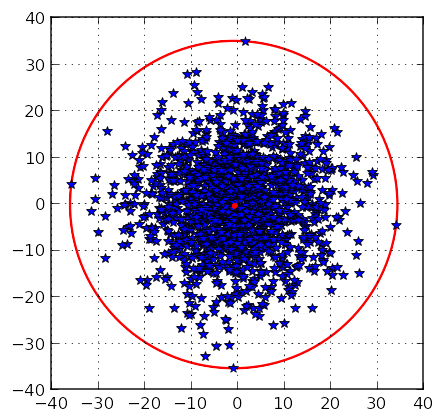

In [78]:
plot_points(p,p0,r0)

Dual Formulation 
-----------------------

The dual problem can be determined in few steps following basic rules. Introducing dual variables

\begin{equation}
 Y = \left( \begin{array}{c} y_1^T\\ \vdots \\y_k  \end{array}\right), \quad z = \left( \begin{array}{c} z_1\\ \vdots \\z_k  \end{array}\right), 
\end{equation}

the dual is:

\begin{aligned}
    \max & \left\langle P, Y \right\rangle \\
    & e_k^T z = 1\\
    & Y^T e_k = \mathbf{0}_n \\
    & \left[z_i , y_i\right] \in \mathcal{Q}^{n+1}\\
    & z_i\in \mathbb{R}, y_i\in \mathbb{R}^n,
\end{aligned}

where $e_k\in \mathbb{R}^k$ is a vector of all ones.

The ``Fusion`` code is the following:


In [79]:
def dual_problem(P):
        
    k= len(P)
    if k==0: return -1,[]

    n= len(P[0])
    
    with Model("minimal sphere enclosing a set of points - dual") as M:
  
        Y= M.variable(NDSet(k,n), Domain.unbounded())
        z= M.variable(k,Domain.unbounded())
                    
        M.constraint(Expr.sum(z), Domain.equalsTo(1.) )
        
        e= [1.0 for i in range(k)]
        M.constraint(Expr.mul(Y.transpose(),e), Domain.equalsTo(0.) )

        M.constraint( Expr.hstack(z,Y), Domain.inQCone())
        
        M.objective( ObjectiveSense.Maximize, Expr.dot( DenseMatrix(P), Y )) 
  
        M.setLogHandler(open('logd','wt'))

        M.solve()

    
dual_problem(p)

Let's take a closer look to the solver output:

In [98]:
!tail  logp

7   5.1e-05  9.2e-06  1.8e-05  1.09e+00   3.531488879e+01   3.541277546e+01   9.2e-06  0.05  
8   8.7e-06  1.6e-06  3.1e-06  1.01e+00   3.522592845e+01   3.524184720e+01   1.6e-06  0.05  
9   6.7e-07  1.2e-07  2.4e-07  1.00e+00   3.522144639e+01   3.522253537e+01   1.2e-07  0.06  
10  9.3e-08  1.7e-08  3.3e-08  1.00e+00   3.522097688e+01   3.522112629e+01   1.7e-08  0.06  
11  3.4e-08  5.7e-09  9.5e-09  1.00e+00   3.522088995e+01   3.522093897e+01   5.7e-09  0.07  
12  2.9e-08  4.7e-09  7.6e-09  9.87e-01   3.522088897e+01   3.522092775e+01   4.7e-09  0.07  
13  9.3e-09  1.5e-09  7.7e-09  9.85e-01   3.522088394e+01   3.522088776e+01   1.5e-09  0.08  
Interior-point optimizer terminated. Time: 0.08. 

Optimizer terminated. Time: 0.08    


In [100]:
!tail logd

9   1.8e-04  5.3e-07  1.2e-07  1.00e+00   3.522253537e+01   3.522144217e+01   1.2e-07  0.03  
10  2.5e-05  7.4e-08  1.7e-08  1.00e+00   3.522112629e+01   3.522097630e+01   1.7e-08  0.03  
11  8.5e-06  2.5e-08  5.6e-09  1.00e+00   3.522093890e+01   3.522088975e+01   5.7e-09  0.03  
12  2.6e-06  7.7e-09  6.1e-10  1.00e+00   3.522089678e+01   3.522088626e+01   1.7e-09  0.03  
13  3.0e-07  8.9e-10  4.3e-11  1.00e+00   3.522088478e+01   3.522088366e+01   2.0e-10  0.04  
14  2.5e-08  6.5e-11  1.3e-08  1.00e+00   3.522088400e+01   3.522088345e+01   1.5e-11  0.04  
15  2.5e-08  6.5e-11  1.3e-08  1.00e+00   3.522088400e+01   3.522088345e+01   1.5e-11  0.04  
Interior-point optimizer terminated. Time: 0.04. 

Optimizer terminated. Time: 0.04    


**How do we explain the differences in running time?**

We know that th ecomplexity of solving the primal or dual is the same. What about the dimensions?

Let's look at the solver output again:

In [117]:
!echo Primal `grep var logp | grep -v Opt`
!echo Dual `grep var logd | grep -v Opt`

Primal Scalar variables : 4503 Matrix variables : 0 Integer variables : 0
Dual Scalar variables : 9000 Matrix variables : 0 Integer variables : 0


In [118]:
!echo Primal `grep Constr logp | grep -v Opt`
!echo Dual `grep Constr logd | grep -v Opt`

Primal Constraints : 4500
Dual Constraints : 4503


In [119]:
!echo Primal `grep Cone logp | grep -v Opt`
!echo Dual `grep Cone logd | grep -v Opt`

Primal Cones : 1500
Dual Cones : 1500


**Why is the number of variable so different from our formulation?**

`Fusion` performs the following transformation:

\begin{equation}
Ax - b \in \mathcal{K} \rightarrow \quad \left\lbrace\begin{array}{ll} y = Ax-b\\ y\in \mathcal{K} \end{array}\right.
\end{equation}

The reason is to ensure that each variable belongs only in one cone. 

**What is then the reason of the different running time?**

* **MOSEK** uses a primal-dual algorithm that solves both primal and dual at the same time,
* therefore internally there is no difference in terms of problem size.

**So why is the dual formulation so much faster?**

The answer comes from a closer inspection to the solver output, in particular the reported `flops`:


In [120]:
!grep flop log* 

logd:Factor     - dense dim.             : 0                 flops                  : 3.90e+04        
logp:Factor     - dense dim.             : 5                 flops                  : 2.91e+05        


In [121]:
!grep flop log* | cut -d':' -f 4 | xargs printf "1/(%f/%f)\n" | bc -l

7.46153846153846153889


In [122]:
!grep "Interior-point optimizer" log* | cut -d':' -f 3| cut -d'.' -f1-2  | xargs printf "1/(%f/%f)\n" | bc -l

2.00000000000000000000


When moving from theory to practical implementation, **MOSEK** is somehow biased towards the primal, i.e. the formulation we input:

* some steps, most notably factorizations, are in practice order dependent,
* it is important to not be mislead by the problem dimension looking only at the number of variables, constraints and cones,
* if performance are a concern, both primal and dual should be tried.

---------------------------------------------------------------------------------------------------------------

The **MOSEK** logo and name are trademarks of Mosek ApS.

The code is provided as-is. Compatibility with future release of **MOSEK** or the `Fusion API` are not guaranteed.

For more information contact [support_at_mosek.com](mailto:support@mosek.com)

---------------------------------------------------------------------------------------------------------------


<a rel="license" href="http://creativecommons.org/licenses/by/4.0/"><img alt="Creative Commons License" style="border-width:0" src="https://i.creativecommons.org/l/by/4.0/88x31.png" /></a><br /><span xmlns:dct="http://purl.org/dc/terms/" property="dct:title">The MOSEK collection of iPython Notebook</span> by <a xmlns:cc="http://creativecommons.org/ns#" href="www.mosek.com" property="cc:attributionName" rel="cc:attributionURL">MOSEK ApS</a> is licensed under a <a rel="license" href="http://creativecommons.org/licenses/by/4.0/">Creative Commons Attribution 4.0 International License</a>.<br />Based on a work at <a xmlns:dct="http://purl.org/dc/terms/" href="https://github.com/MOSEK" rel="dct:source">https://github.com/MOSEK</a>.<br />Permissions beyond the scope of this license may be available at <a xmlns:cc="http://creativecommons.org/ns#" href="www.mosek.com" rel="cc:morePermissions">www.mosek.com</a>.

In [85]:
!cat logp

Computer
  Platform               : Linux/64-X86    

Problem
  Name                   : minimal sphere enclosing a set of points - primal
  Objective sense        : min             
  Type                   : CONIC (conic optimization problem)
  Constraints            : 4500            
  Cones                  : 1500            
  Scalar variables       : 4503            
  Matrix variables       : 0               
  Integer variables      : 0               

Optimizer started.
Conic interior-point optimizer started.
Presolve started.
Linear dependency checker started.
Linear dependency checker terminated.
Eliminator - tries                  : 0                 time                   : 0.00            
Eliminator - elim's                 : 0               
Lin. dep.  - tries                  : 1                 time                   : 0.00            
Lin. dep.  - number                 : 0               
Presolve terminated. Time: 0.01    
Optimizer  - threads                : 2   

In [86]:
!cat logd

Computer
  Platform               : Linux/64-X86    

Problem
  Name                   : minimal sphere enclosing a set of points - dual
  Objective sense        : max             
  Type                   : CONIC (conic optimization problem)
  Constraints            : 4503            
  Cones                  : 1500            
  Scalar variables       : 9000            
  Matrix variables       : 0               
  Integer variables      : 0               

Optimizer started.
Conic interior-point optimizer started.
Presolve started.
Linear dependency checker started.
Linear dependency checker terminated.
Eliminator - tries                  : 0                 time                   : 0.00            
Eliminator - elim's                 : 0               
Lin. dep.  - tries                  : 1                 time                   : 0.00            
Lin. dep.  - number                 : 0               
Presolve terminated. Time: 0.01    
Optimizer  - threads                : 2     